In [122]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [123]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf()) #get current axis
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [124]:
mean = (2, 3)
cov = [[4, -3], [-3, 9]]
data = np.random.multivariate_normal(mean, cov, 100)
print(data.shape)

(100, 2)


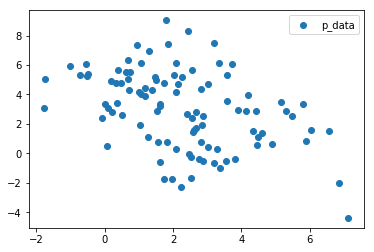

In [125]:
plt.scatter(data[:,0],data[:,1],label = 'p_data')
plt.legend()

In [126]:
class make_data():
    
    def __init__(self, mean, cov, num_sample):
        self.mean = mean
        self.cov = cov
        self.data = np.random.multivariate_normal(mean, cov, num_sample)
        self.len = self.data.shape[0]
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

In [127]:
mean = (2, 3)
cov = [[4, -3], [-3, 9]]
num_sample = 100
dataset = make_data(mean,cov,num_sample)

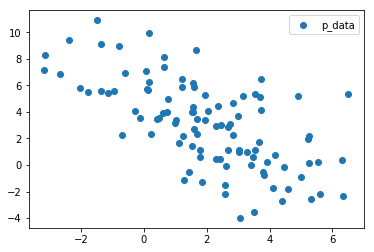

In [128]:
plt.scatter(dataset.data[:,0],dataset.data[:,1],label = 'p_data')
plt.legend()

In [129]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
num_batches = len(data_loader)
print('num_batches: ', num_batches)

num_batches:  10


In [130]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            #nn.Tanh() #Tanh because output image = [0,1]
        )

    def forward(self, x):
        #print("generator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

In [131]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        #print("discriminator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x
    
# def images_to_vectors(images):
#     return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)

In [132]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)
#device = 1
if torch.cuda.is_available():
    discriminator.cuda(device)
    generator.cuda(device)

Configured device:  cuda:2


In [133]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 100

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

In [134]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

In [135]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data.float())
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data.float())
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [136]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data.float())
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [137]:
# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 2) #[size vector of length 100]
    if torch.cuda.is_available(): return n.cuda(device) 
    return n

num_test_samples = 200
test_noise = noise(num_test_samples)

In [138]:
def plt_output(fake_data,real_data):
    plt.figure(figsize=(4,4))
    plt.scatter(fake_data[:,0], fake_data[:,1],label = 'p_x')
    plt.scatter(real_data.data[:,0], real_data.data[:,1],label = 'p_data')
    plt.legend()
    plt.show()

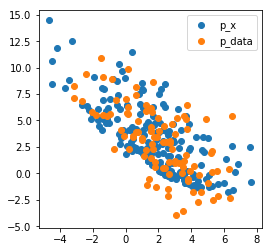

Epoch: [99/100], Batch Num: [0/10]
Discriminator Loss: 1.4213, Generator Loss: 0.7119
D(x): 0.4978, D(G(z)): 0.5110


In [139]:

logger = Logger(model_name='VGAN', data_name='Midterm')

d_loss = []
g_loss = []

for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(data_loader):
        # Train discriminator on a real batch and a fake batch
        
        #real_data = images_to_vectors(real_batch)
        real_data = real_batch
        real_data = real_data.cuda(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        d_loss.append(d_error)
        g_loss.append(g_error)
        
        # Log errors and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 5 == 0:
            display.clear_output(True)
            # Display Images
            test_plot = plt_output(generator(test_noise).cpu().detach().numpy(),dataset)
            #logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

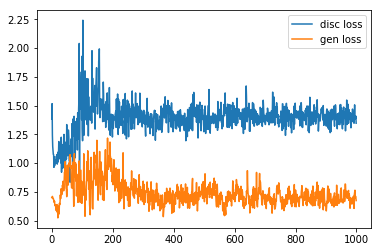

In [141]:
plt.plot(d_loss, label = 'disc loss')
plt.plot(g_loss, label = 'gen loss')
plt.legend()
plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display', 'cov', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


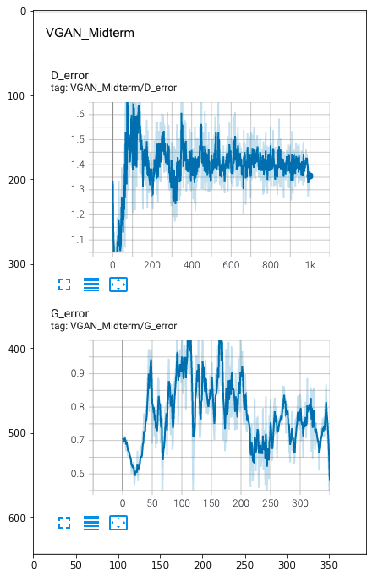

In [121]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('tensor_board.png')
plt.figure(figsize = (20,10))
imgplot = plt.imshow(img)
plt.show()